In [1]:
!pip install seqeval
!pip install matplotlib
!pip install livelossplot
!pip install --upgrade gensim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import tensorflow

from seqeval.metrics import f1_score, accuracy_score, classification_report

from tensorflow import keras
from keras import Model, Input
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import LSTM, Embedding, Dense, InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional, Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=c8028067935d7db70f9c6eb9eff1f5e380c2c6056113b07ffdbfbfc90205b387
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


# 1.1 Word Embedding

In [2]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))
word2vec = gensim.downloader.load('word2vec-google-news-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[==================================================] 100.0% 1662.8/1662.8MB downloaded


## Question 1.1

Based on word2vec embeddings, use cosine similarity to find the most similar word to each of these words: “student”, “Apple” and “apple”. Report the most similar word and its cosine similarity.

In [3]:
word2vec.most_similar('student')

[('students', 0.7294867038726807),
 ('Student', 0.6706662774085999),
 ('teacher', 0.6301366090774536),
 ('stu_dent', 0.6240993142127991),
 ('faculty', 0.6087332963943481),
 ('school', 0.6055627465248108),
 ('undergraduate', 0.6020305752754211),
 ('university', 0.600540041923523),
 ('undergraduates', 0.5755698680877686),
 ('semester', 0.573759913444519)]

In [4]:
word2vec.most_similar('Apple')

[('Apple_AAPL', 0.7456986308097839),
 ('Apple_Nasdaq_AAPL', 0.7300410270690918),
 ('Apple_NASDAQ_AAPL', 0.717508852481842),
 ('Apple_Computer', 0.7145972847938538),
 ('iPhone', 0.6924266219139099),
 ('Apple_NSDQ_AAPL', 0.6868603229522705),
 ('Steve_Jobs', 0.6758421659469604),
 ('iPad', 0.6580768823623657),
 ('Apple_nasdaq_AAPL', 0.6444970369338989),
 ('AAPL_PriceWatch_Alert', 0.6439753174781799)]

In [5]:
word2vec.most_similar('apple')

[('apples', 0.720359742641449),
 ('pear', 0.6450697183609009),
 ('fruit', 0.6410146355628967),
 ('berry', 0.6302295327186584),
 ('pears', 0.613396167755127),
 ('strawberry', 0.6058260798454285),
 ('peach', 0.6025872826576233),
 ('potato', 0.5960935354232788),
 ('grape', 0.5935863852500916),
 ('blueberry', 0.5866668224334717)]

# Part 1. Sequence Tagging: NER

## 1.2 Data

### Training data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
sequences_word = []
sequences_label = []
sentence_word = []
sentence_label = []

with open('/content/drive/MyDrive/CZ4045NaturalLanguageProcessing/datasets/eng.train', 'r') as file:
# with open('/content/drive/MyDrive/nlp_datasets/eng.train', 'r') as file:
  for line in file:
    line_data = line.strip().split()
    if len(line_data) >= 2:
      sentence_word.append(line_data[0])
      sentence_label.append(line_data[-1])
    else:
      sequences_word.append(sentence_word)
      sequences_label.append(sentence_label)
      sentence_word = []
      sentence_label = []

df_train = pd.DataFrame({'sequences_word': sequences_word, 'sequences_label': sequences_label})

In [8]:
# remove -DOCSTART-
df_train = df_train[~df_train['sequences_word'].apply(lambda x: any('-DOCSTART-' in i for i in x))]

# create new columns for clear sentences (remove punctuations)
df_train['clear_sequences_word'] = df_train['sequences_word'].apply(lambda seq: [x for x in seq if re.search('[a-zA-Z0-9]', x)])
df_train['clear_sequences_label'] = df_train.apply(lambda row: [label for i, label in enumerate(row['sequences_label']) if re.search('[a-zA-Z0-9]', row['sequences_word'][i])], axis=1)

# remove rows where clear sentence has length 0
df_train = df_train[df_train['clear_sequences_word'].apply(len) > 0]

# remove some stopwords
stopwords_list = ['to', 'a', 'of', 'and', '\'s']
df_train['clear_words'] = df_train['clear_sequences_word'].apply(lambda seq: [x for x in seq if x not in stopwords_list])
df_train['clear_labels'] = df_train.apply(lambda row: [label for i, label in enumerate(row['clear_sequences_label']) if row['clear_sequences_word'][i] not in stopwords_list], axis=1)


<ipython-input-8-f1740f08b6c4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['clear_words'] = df_train['clear_sequences_word'].apply(lambda seq: [x for x in seq if x not in stopwords_list])


In [9]:
def generate_random_vector():
    return np.random.uniform(-1, 1, 300)  # 300 random floats in the range [-1, 1]

def get_word_vector(word):
    try:
        return word2vec[word]
    except KeyError:
        # deal with unknown words
        return generate_random_vector()

df_train['sequences_wordvec'] = df_train['clear_words'].apply(
    lambda x: [get_word_vector(word) for word in x]
)

In [10]:
sequences_word = df_train['clear_words'].tolist()
sequences_wordvec = df_train['sequences_wordvec'].tolist()
sequences_label = df_train['clear_labels'].tolist()

### Development data

In [11]:
sequences_word_develop = []
sequences_label_develop = []
sentence_word = []
sentence_label = []

with open('/content/drive/MyDrive/CZ4045NaturalLanguageProcessing/datasets/eng.testa', 'r') as file:
# with open('/content/drive/MyDrive/nlp_datasets/eng.testa', 'r') as file:
  for line in file:
    line_data = line.strip().split()
    if len(line_data) >= 2:
      sentence_word.append(line_data[0])
      sentence_label.append(line_data[-1])
    else:
      sequences_word_develop.append(sentence_word)
      sequences_label_develop.append(sentence_label)
      sentence_word = []
      sentence_label = []

df_develop = pd.DataFrame({'sequences_word': sequences_word_develop, 'sequences_label': sequences_label_develop})

In [12]:
# remove -DOCSTART-
df_develop = df_develop[~df_develop['sequences_word'].apply(lambda x: any('-DOCSTART-' in i for i in x))]

# create new columns for clear sentences (remove punctuations)
df_develop['clear_sequences_word'] = df_develop['sequences_word'].apply(lambda seq: [x for x in seq if re.search('[a-zA-Z0-9]', x)])
df_develop['clear_sequences_label'] = df_develop.apply(lambda row: [label for i, label in enumerate(row['sequences_label']) if re.search('[a-zA-Z0-9]', row['sequences_word'][i])], axis=1)

# remove rows where clear sentence has length 0
df_develop = df_develop[df_develop['clear_sequences_word'].apply(len) > 0]

# remove some stopwords
stopwords_list = ['to', 'a', 'of', 'and', '\'s']
df_develop['clear_words'] = df_develop['clear_sequences_word'].apply(lambda seq: [x for x in seq if x not in stopwords_list])
df_develop['clear_labels'] = df_develop.apply(lambda row: [label for i, label in enumerate(row['clear_sequences_label']) if row['clear_sequences_word'][i] not in stopwords_list], axis=1)

<ipython-input-12-3ad3a7854da7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_develop['clear_words'] = df_develop['clear_sequences_word'].apply(lambda seq: [x for x in seq if x not in stopwords_list])


In [13]:
df_develop['sequences_wordvec'] = df_develop['clear_words'].apply(
    lambda x: [get_word_vector(word) for word in x]
)

sequences_wordvec_develop = df_develop['sequences_wordvec'].tolist()
sequences_label_develop = df_develop['clear_labels'].tolist()

### Test data

In [14]:
sequences_word_test = []
sequences_label_test = []
sentence_word = []
sentence_label = []

with open('/content/drive/MyDrive/CZ4045NaturalLanguageProcessing/datasets/eng.testb', 'r') as file:
# with open('/content/drive/MyDrive/nlp_datasets/eng.testb', 'r') as file:
  for line in file:
    line_data = line.strip().split()
    if len(line_data) >= 2:
      sentence_word.append(line_data[0])
      sentence_label.append(line_data[-1])
    else:
      sequences_word_test.append(sentence_word)
      sequences_label_test.append(sentence_label)
      sentence_word = []
      sentence_label = []

df_test = pd.DataFrame({'sequences_word': sequences_word_test, 'sequences_label': sequences_label_test})

In [15]:
# remove -DOCSTART-
df_test = df_test[~df_test['sequences_word'].apply(lambda x: any('-DOCSTART-' in i for i in x))]

# create new columns for clear sentences (remove punctuations)
df_test['clear_sequences_word'] = df_test['sequences_word'].apply(lambda seq: [x for x in seq if re.search('[a-zA-Z0-9]', x)])
df_test['clear_sequences_label'] = df_test.apply(lambda row: [label for i, label in enumerate(row['sequences_label']) if re.search('[a-zA-Z0-9]', row['sequences_word'][i])], axis=1)

# remove rows where clear sentence has length 0
df_test = df_test[df_test['clear_sequences_word'].apply(len) > 0]

# remove some stopwords
stopwords_list = ['to', 'a', 'of', 'and', '\'s']
df_test['clear_words'] = df_test['clear_sequences_word'].apply(lambda seq: [x for x in seq if x not in stopwords_list])
df_test['clear_labels'] = df_test.apply(lambda row: [label for i, label in enumerate(row['clear_sequences_label']) if row['clear_sequences_word'][i] not in stopwords_list], axis=1)


<ipython-input-15-fff8bacd01cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['clear_sequences_word'] = df_test['sequences_word'].apply(lambda seq: [x for x in seq if re.search('[a-zA-Z0-9]', x)])
<ipython-input-15-fff8bacd01cf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['clear_words'] = df_test['clear_sequences_word'].apply(lambda seq: [x for x in seq if x not in stopwords_list])


In [16]:
df_test['sequences_wordvec'] = df_test['clear_words'].apply(
    lambda x: [get_word_vector(word) for word in x]
)

sequences_wordvec_test = df_test['sequences_wordvec'].tolist()
sequences_label_test = df_test['clear_labels'].tolist()

### Preprocessing

In [17]:
!nvidia-smi
print('Tensorflow version:', tensorflow.__version__)
print('GPU detected:', tensorflow.config.list_physical_devices('GPU'))
physical_devices = tensorflow.config.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

Fri Nov 10 11:19:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
labels = df_train.explode('clear_labels')
unique_labels = list(set(labels['clear_labels'].values))
unique_labels.append('B-PER')
unique_labels

['I-ORG', 'I-PER', 'I-MISC', 'B-MISC', 'I-LOC', 'O', 'B-ORG', 'B-LOC', 'B-PER']

In [20]:
label2id = {t: i for i, t in enumerate(unique_labels)}
id2label = {i: t for t, i in label2id.items()}

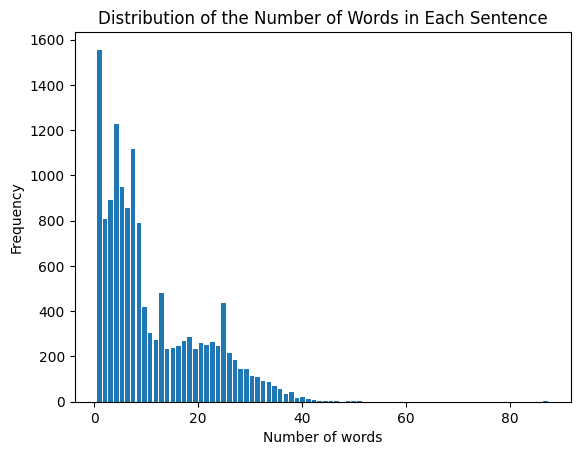

In [21]:
df_train['number_of_words'] = df_train['clear_words'].apply(len)
# Plot the histogram
plt.hist(df_train['number_of_words'], bins=80, align='left', rwidth=0.8)
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.title("Distribution of the Number of Words in Each Sentence")
plt.show()

In [24]:
max_sentence_len = 50

x_train = pad_sequences(maxlen=max_sentence_len, sequences=sequences_wordvec, dtype='float32', padding="post")

y_train = [[label2id[l] for l in s] for s in sequences_label]
y_train = pad_sequences(maxlen=max_sentence_len, sequences=y_train, padding="post", value=label2id['O'])

# x_train.shape = (13990, 50, 300)
# y_train.shape = (13990, 50)

In [25]:
x_develop = pad_sequences(maxlen=max_sentence_len, sequences=sequences_wordvec_develop, dtype='float32', padding="post")

y_develop = [[label2id[l] for l in s] for s in sequences_label_develop]
y_develop = pad_sequences(maxlen=max_sentence_len, sequences=y_develop, padding="post", value=label2id['O'])


In [26]:
x_test = pad_sequences(maxlen=max_sentence_len, sequences=sequences_wordvec_test, dtype='float32', padding="post")

y_test = [[label2id[l] for l in s] for s in sequences_label_test]
y_test = pad_sequences(maxlen=max_sentence_len, sequences=y_test, padding="post", value=label2id['O'])

## 1.3 Model

In [38]:
word_vector_dim = 300
max_sentence_len = 50

model = Sequential()
model.add(InputLayer((max_sentence_len, word_vector_dim)))
model.add(Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(9, activation='softmax')))

model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

# Display the model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 50, 1024)          3330048   
 onal)                                                           
                                                                 
 time_distributed_3 (TimeDi  (None, 50, 9)             9225      
 stributed)                                                      
                                                                 
Total params: 3339273 (12.74 MB)
Trainable params: 3339273 (12.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


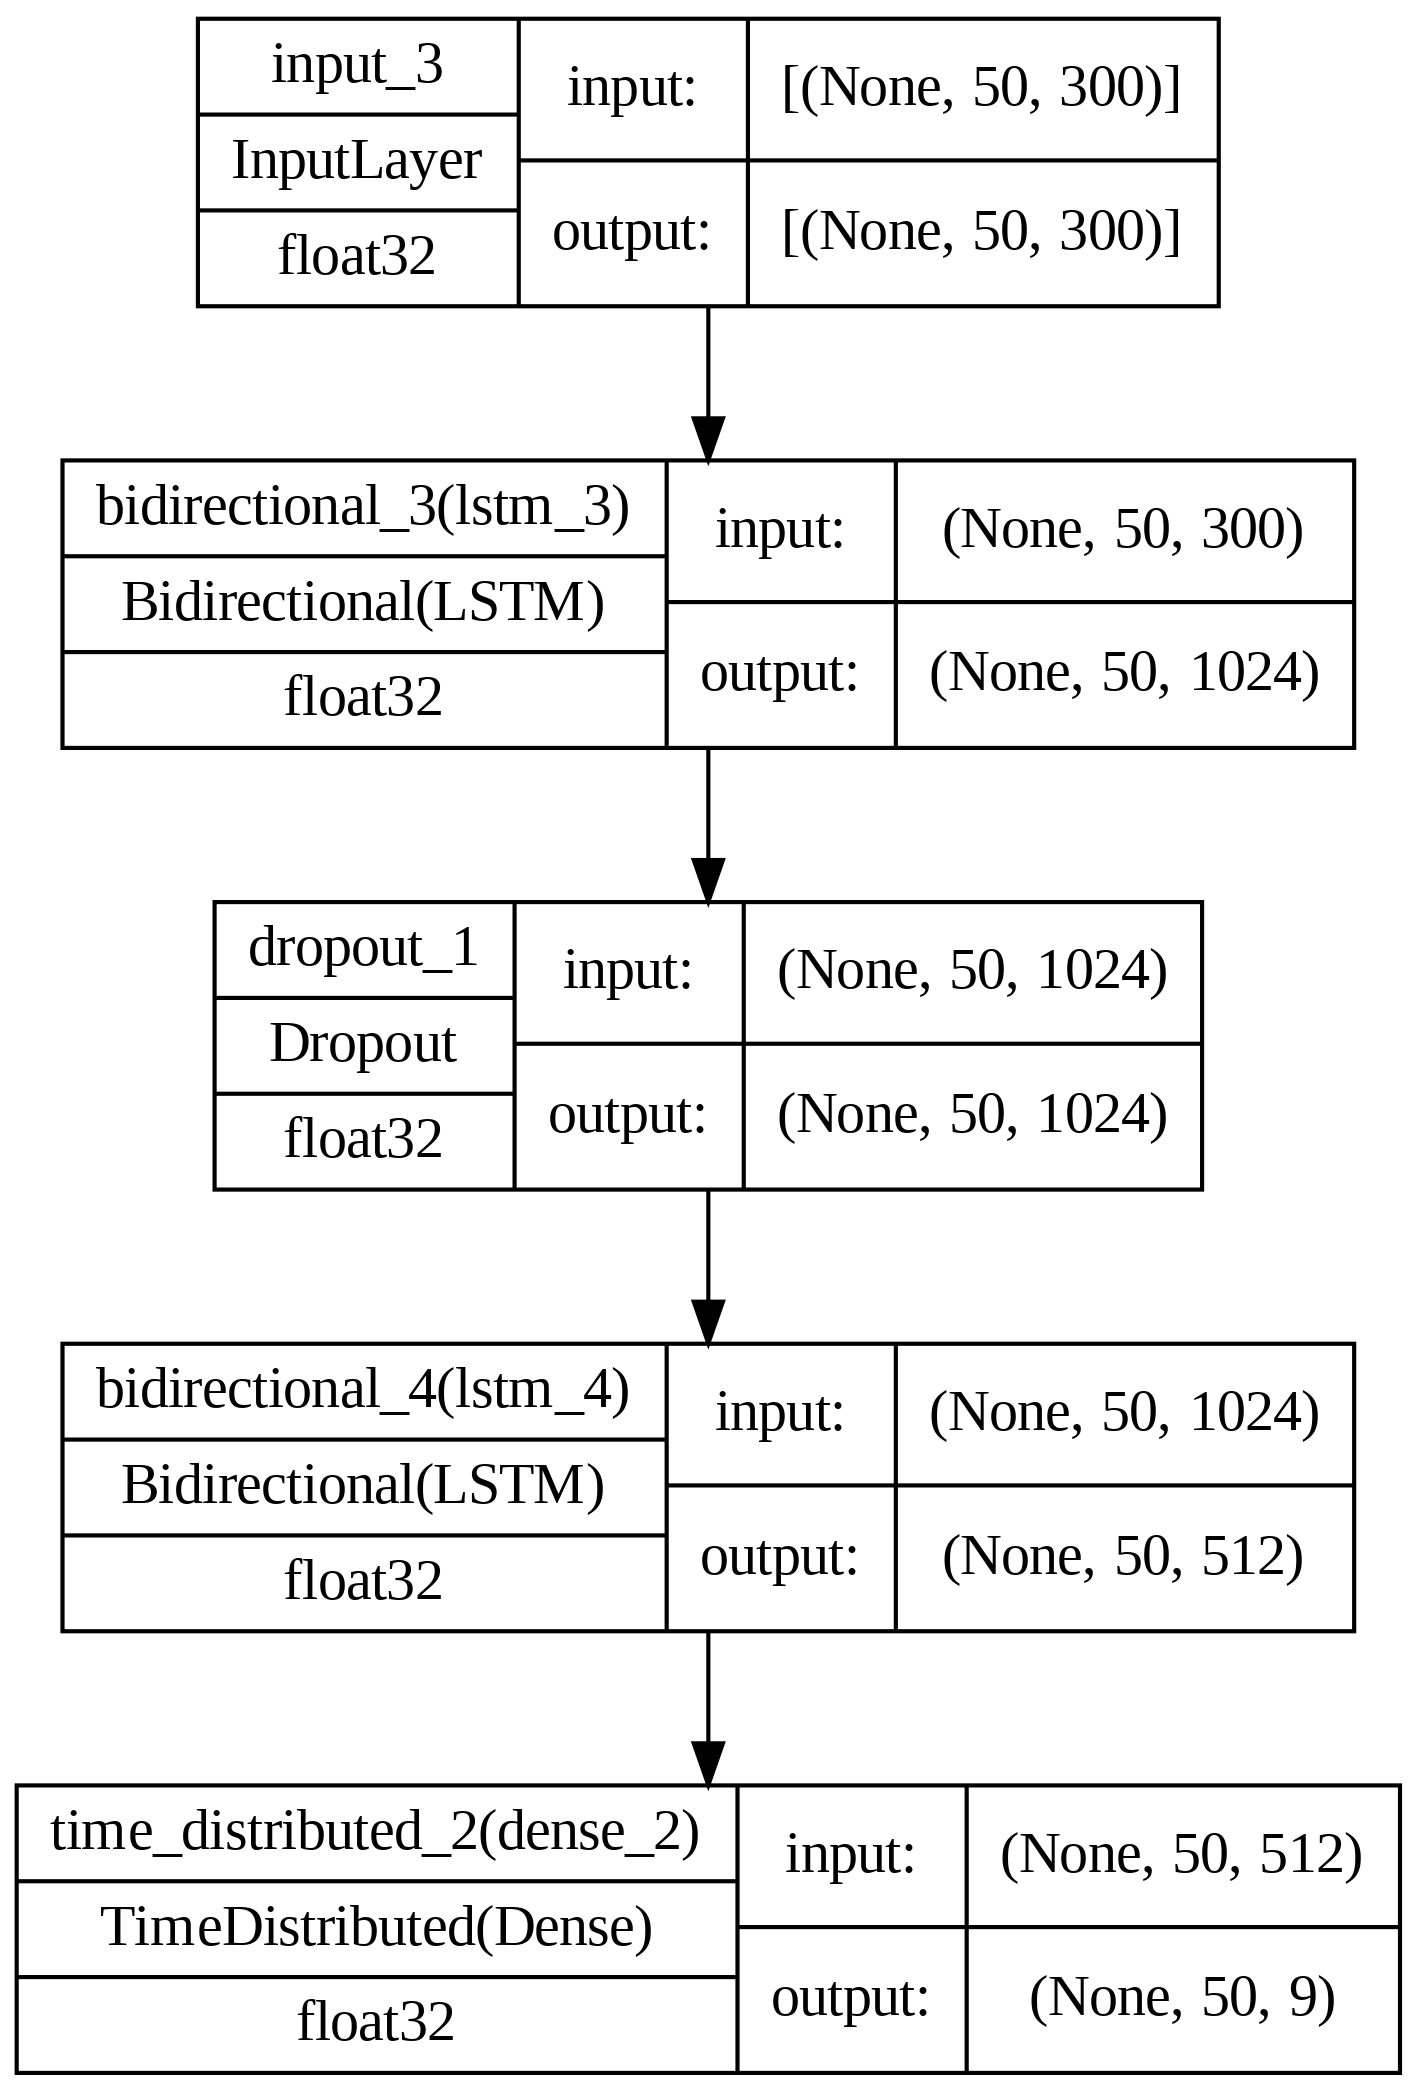

In [34]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=300,
)

In [28]:
# Custom evaluation function
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        print('Evaluation for epoch ', epoch, ':')
        y_true = y_val
        y_pred = self.model.predict(x_val)
        label_pred = [[id2label[np.argmax(w)] for w in sen] for sen in y_pred]
        label_true = [[id2label[l] for l in s] for s in y_true]
        f1 = f1_score(label_true, label_pred)
        print('f1 score: ', f1)
        # classification_report(label_true, label_pred)

        if f1 > self.best_f1:
            self.best_f1 = f1
        else:
            self.model.stop_training = True


In [39]:
import time

start_time = time.time()

model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=20,
   callbacks=[F1ScoreCallback(validation_data = (x_develop, y_develop))],
)

end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

Epoch 1/20
102/102 [==============================] - 4s 36ms/step
f1 score:  0.7092573037662795
438/438 [==============================] - 186s 408ms/step - loss: 0.1001 - accuracy: 0.9756
Epoch 2/20
102/102 [==============================] - 5s 48ms/step
f1 score:  0.7650863978732833
438/438 [==============================] - 178s 407ms/step - loss: 0.0432 - accuracy: 0.9879
Epoch 3/20
102/102 [==============================] - 4s 37ms/step
f1 score:  0.7898077940398519
438/438 [==============================] - 178s 406ms/step - loss: 0.0302 - accuracy: 0.9915
Epoch 4/20
102/102 [==============================] - 5s 47ms/step
f1 score:  0.8071344923880732
438/438 [==============================] - 178s 407ms/step - loss: 0.0207 - accuracy: 0.9941
Epoch 5/20
102/102 [==============================] - 4s 38ms/step
f1 score:  0.8149127445795875
438/438 [==============================] - 175s 399ms/step - loss: 0.0140 - accuracy: 0.9960
Epoch 6/20
102/102 [==============================

In [40]:
test_pred = model.predict(x_test)

label_pred = [[id2label[np.argmax(w)] for w in sen] for sen in test_pred]
label_true = [[id2label[l] for l in s] for s in y_test]

print('f1 score for test dataset:', f1_score(label_true, label_pred))
classification_report(label_true, label_pred)

108/108 [==============================] - 4s 36ms/step
f1 score for test dataset: 0.7666297117516631


'              precision    recall  f1-score   support\n\n         LOC       0.83      0.81      0.82      1545\n        MISC       0.70      0.68      0.69       692\n         ORG       0.68      0.77      0.72      1598\n         PER       0.80      0.80      0.80      1502\n\n   micro avg       0.76      0.78      0.77      5337\n   macro avg       0.75      0.76      0.76      5337\nweighted avg       0.76      0.78      0.77      5337\n'